## Library and Datasets

In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

In [3]:
births = pd.read_csv('../data/processed/totDF_dwnsmpl_clean.csv')
births_nou = births.loc[births['admit_NICU'] != 'U'] 
#births

## Functions

In [28]:
# Mask a category in a feature 
#Example remove all 'U' for target feature
def remove_category(dataframe, column = str, category = 'U'):
    return dataframe.loc[dataframe[column] != category]

#Value counts for target column, and value counts for target column when group be year
def val_check(data_frame, column_name = str):
    df = pd.DataFrame(data_frame)
    print( "Value counts of %s \n" %(col), df[col].value_counts())
    print("Value counts of %s by year \n" %(col), df.groupby(['birth_year'])[column_name].value_counts())

# Make a dataframe suitable for plotting a stacked bar graph with percentage of total as values for each sub category
def make_pctdf(dataframe , group = str, target = 'admit_NICU',  columns_titles = ['Y','N']):
    df1 = dataframe.loc[(dataframe[group] == 'Y')].groupby([group])[[target]].count()
    df2 = dataframe.loc[(dataframe[group] == 'Y')].groupby([group])[target].value_counts().unstack().reindex(
        columns=columns_titles)
    df3 = pd.merge(df1,df2, left_index = True, right_index = True)
    return pd.DataFrame(list(map(lambda x: df3[x]/df3[target] * 100, df3.columns[1:]))).T

#Make a dataframe suitable for plotting a bar graph with counts of one subcategory of feature
#For example inlcude only observations marked 'Y', exclude other values
def make_cntdf(dataframe , group = str, filter_output = 'Y', target = 'admit_NICU',  columns_titles = ['Y','N']):
    return dataframe.loc[(dataframe[group] == filter_output)].groupby([group])[[target]].count()
 
#################save plots, run within plotting cells ###################################
def saveplt(filename):
    path = './Saved_Visualizations/'
    file1 = path + filename + '.pdf'
    file2 = path + filename + '.png'
    plt.savefig(file1) #as pdf
    plt.savefig(file2) #as png
    
################ Horizontal bar graph for single reclassed numeric features ############################
def pct_bplot(dataframe, group, target = 'admit_NICU', title = 'Title',savefile = 'savename', columns_titles = ['Y','N'] ):
    df1 = dataframe.groupby([group])[[target]].count()
    df2 = dataframe.groupby([group])[target].value_counts().unstack().reindex(columns=columns_titles)
    df3 = pd.merge(df1,df2, left_index = True, right_index = True)
    pct_df = pd.DataFrame(list(map(lambda x: df3[x]/df3[target] * 100, df3.columns[1:]))).T
    df_plt = pct_df.plot(kind = 'barh', stacked = True, legend = False, figsize = (10,9)) 
    #Formatting   
    df_plt.axvline(x=(8.7), color='r', linestyle='-')
    df_plt.set_title(title, fontsize = 16)
    df_plt.set_ylabel('')
    #Legend
    leg = df_plt.legend(labels=[' Average Rate of Admittance, 8.7%', 'Admitted to NICU', 
                          'Normal Birth'],fontsize= 10, loc = 'lower center')
    bb = leg.get_bbox_to_anchor().inverse_transformed(df_plt.transAxes)  # Get the bounding box of the original legend
    # Change to location of the legend. 
    offset = -.2
    bb.y0 += offset
    bb.y1 += offset
    leg.set_bbox_to_anchor(bb, transform = df_plt.transAxes)
    #Add annotation 
    for p in df_plt.patches:
        width, height = p.get_width(), p.get_height()
        val = width/100
        df_plt.annotate('{:0.1%}'.format(val), (p.get_x()+.9*width, p.get_y()+ height*.4),
                          ha = 'center', color = 'white', fontsize = 14)
        
    #Resize plot area to fit within Figure Size
    plt.tight_layout(rect = (0,0,.8,1))
    
    saveplt(savefile)
    
############bplot2 for some numeric features that already are recoded (esp baby weight)###################
def pct_bplot2(dataframe, group = str, title = 'Title',savefile = 'plotname', target = 'admit_NICU', columns_titles = ['Y','N']):
    df1 = dataframe.groupby([group])[target].count()
    df2 =  dataframe.groupby([group])[target].value_counts().unstack()
    df2 = df2.reindex(columns=columns_titles)
    df3 = pd.merge(df1,df2, left_index = True, right_index = True)
    pct_df = pd.DataFrame(list(map(lambda x: df3[x]/df3[target], df3.columns[1:]))).T
    #pct_df.plot(kind = 'bar', stacked = True, legend = True)
    df_plt = pct_df.plot(kind = 'barh', stacked = True, legend = True,figsize=(10,12))

#Formatting  
    plt.axvline(x=(8.7/100), color='r', linestyle='-', label = '8.7%')
    #df_plt.set_yticklabels(full_names, fontsize = 12)
    df_plt.set_xticklabels(('0','20','40','60','80', '100'))
    df_plt.set_title(title, fontsize = 16)
    
    #Add annotation 
    for p in df_plt.patches:
        width, height = p.get_width(), p.get_height()
        df_plt.annotate('{:.1%}'.format(width), (p.get_x()+.8*width, p.get_y() + height * .4),
                          ha = 'center', color = 'white', fontsize = 14)
    #Legend
    leg = df_plt.legend(labels=[' Average Rate of Admittance, 8.7%', 
                                'Admitted to NICU', 'Normal Birth'],fontsize= 10, loc = 'lower center')
    bb = leg.get_bbox_to_anchor().inverse_transformed(df_plt.transAxes)# Get the bounding box of the original legend
    xOffset = -.1
    bb.y0 += xOffset
    bb.y1 += xOffset
    leg.set_bbox_to_anchor(bb, transform = df_plt.transAxes) # Change to location of the legend. 
 
    plt.tight_layout(rect = (0,0,.8,1))#Resize plot area to fit within Figure Size
    saveplt(savefile) # Save figure
    
###########Horizontal percent bar graph for multiple boolean features with formatting#############
def pct_bhplot(dataframe, full_names, col_names , target = 'admit_NICU',
               columns_titles = ['Y','N'], title = 'Title', savefile = 'newplot' ):
    df = pd.concat(map( lambda cname: make_pctdf( births_nou, cname ), col_names ))
    df_plt = (df.div(df.sum(1), axis=0)).plot(kind = 'barh', width = 0.8, stacked = True, figsize = (10,9))

    #Formatting  
    plt.axvline(x=(8.7/100), color='r', linestyle='-', label = '8.7%')
    df_plt.set_yticklabels(full_names, fontsize = 12)
    df_plt.set_xticklabels(('0','20','40','60','80', '100'))
    df_plt.set_title(title, fontsize = 16)
    
    #Add annotation 
    for p in df_plt.patches:
        width, height = p.get_width(), p.get_height()
        df_plt.annotate('{:.1%}'.format(width), (p.get_x()+.9*width, p.get_y() + height - .5),
                          ha = 'center', color = 'white', fontsize = 14)
    #Legend
    leg = df_plt.legend(labels=[' Average Rate of Admittance, 8.7%', 
                                'Admitted to NICU', 'Normal Birth'],fontsize= 10, loc = 'lower center')
    bb = leg.get_bbox_to_anchor().inverse_transformed(df_plt.transAxes)# Get the bounding box of the original legend
    xOffset = -.2
    bb.y0 += xOffset
    bb.y1 += xOffset
    leg.set_bbox_to_anchor(bb, transform = df_plt.transAxes) # Change to location of the legend. 
 
    plt.tight_layout(rect = (0,0,.8,1))#Resize plot area to fit within Figure Size
    saveplt(savefile) # Save figure

###########Horizontal bar graph of counts for multiple boolean features with formatting#############
def cnt_bhplot(dataframe, full_names, col_names , target = 'admit_NICU', columns_titles = ['Y','N'], title = 'Title', savefile = 'newplot' ):
    df = pd.concat(map( lambda cname: make_cntdf( births_nou, cname ), col_names ))
    df_plt = df.plot(kind = 'barh', width = 0.8, stacked = True, figsize = (13,9))
    
    #Formatting  
    df_plt.set_yticklabels(full_names, fontsize = 12)
    df_plt.set_title(title, fontsize = 16)
    leg = df_plt.legend(labels=['Admitted to NICU'],fontsize= 10, loc = 'lower center')
    
    #Add annotation 
    for p in df_plt.patches:
        width, height = p.get_width(), p.get_height()
        df_plt.annotate('{:}'.format(int(width)), ( p.get_x()+ width, p.get_y() + height - .5),
                          ha = 'left', color = 'black', fontsize = 12)
    # Get the bounding box of the original legend
    bb = leg.get_bbox_to_anchor().inverse_transformed(df_plt.transAxes)

    # Change to location of the legend. 
    Offset = -.1
    bb.y0 += Offset
    bb.y1 += Offset
    leg.set_bbox_to_anchor(bb, transform = df_plt.transAxes)

    #Resize plot area to fit within Figure Size
    plt.subplots_adjust(right=0.9)  # adjust plot area
    plt.tight_layout()
    saveplt(savefile)
    
#######Vertical bar graph with formatting - do not use at this time#############

def pct_bvplot(dataframe, full_names, col_names , target = 'admit_NICU', columns_titles = ['Y','N'], title = 'Title', savefile = 'newplot' ):
    
    df = pd.concat(map( lambda cname: make_pctdf( births_nou, cname ), col_names ))
    
    df_plt = (df.div(df.sum(1), axis=0)).plot(kind = 'bar', width = 0.8, stacked = True, figsize = (10,9))


    #Formatting  
    plt.axhline(x=(8.7/100), color='r', linestyle='-', label = '8.7%')
    df_plt.set_xticklabels(fullnames_list, fontsize = 12)
    df_plt.set_yticklabels(('0','20','40','60','80', '100'))
    df_plt.set_title(title, fontsize = 16)
    leg = df_plt.legend(labels=[' Average Rate of Admittance, 8.7%', 'Admitted to NICU', 'Normal Birth'],fontsize= 10, loc = 'lower center')
    #Add annotation 
    for p in df_plt.patches:
        width, height = p.get_width(), p.get_height()
        df_plt.annotate('{:.0%}'.format(width), (p.get_x()+ width, p.get_y() + height - .5),
                          ha = 'center', color = 'white', fontsize = 14)

    # Get the bounding box of the original legend
    bb = leg.get_bbox_to_anchor().inverse_transformed(df_plt.transAxes)

    # Change to location of the legend. 
    xOffset = -.2
    bb.y0 += xOffset
    bb.y1 += xOffset
    leg.set_bbox_to_anchor(bb, transform = df_plt.transAxes)

    #Resize plot area to fit within Figure Size
    plt.tight_layout(rect = (0,0,.8,1))
    
    saveplt(savefile)   
    
#plot time series for target column
def plot_gpYR(dataframe,col,xlab,ylab,title,kind='line'):
    dataframe.groupby('birth_year')[col].value_counts().unstack().plot(kind=kind,logy=True, legend=True)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    leg = plt.legend(loc = 'best')
#      # Change to location of the legend. 
#     bb = leg.get_bbox_to_anchor().inverse_transformed(plt.transAxes)
#     xOffset = -.2
#     bb.y0 += xOffset
#     bb.y1 += xOffset
#     leg.set_bbox_to_anchor(bb, transform = plt.transAxes)
    return
#######################  plot count graphs over the pct_bplots
def plt_scatter_sub(df_x,df_y,title):
    
    #new Dataframe to be able to pull annotations
    x = pd.DataFrame(df_x[0])
    x = x.reset_index()
    y = pd.DataFrame(df_y)
    y = y.reset_index()

    plt.scatter(x = df_x[0], y = df_y)
    plt.title(title)
    plt.xlabel('Percentage Admitted')
    plt.ylabel('Count admitted')
    

    #plt.axvline(x=8.7, color='r', linestyle='-')
    ymin,ymax = plt.ylim()
    xmin,xmax = plt.xlim()
    xmid = (xmax-xmin)/2
    ymid = (ymax-ymin)/2
#     print(ymin,ymax, ymid)
#     print(xmin,xmax,xmid)
    plt.axvline(x = xmid+xmin, color='r', linestyle='-')
    plt.axhline(y = ymid+xmin, color='r', linestyle='-')
    plt.grid()
    for i, txt in enumerate(fullnames_list):
        plt.annotate(txt, (x[0][i], y['admit_NICU'][i]))
    plt.tight_layout(rect = (0,0,1,1))
    saveplt(title)

def plt_scatter(dataframe,cnames_list, fullnames_list, title = 'Title'):
    pct_df = pd.concat(map( lambda cname: make_pctdf( dataframe, cname ), cnames_list ))
    count_df = pd.concat(map( lambda cname: make_cntdf( dataframe, cname ), cnames_list ))
    plt_scatter_sub(pct_df,count_df,title)
   

## Group Lists and Recoded Columns


In [37]:
#Columns recoded for better display
births['mother_bmi_recode'] = pd.cut(births['mothers_bmi'],[10.0,19.0, 25.0,30.0,35.0,40.0,90.0], 
                                     labels = ['u','h','o','ob1','ob2','ob3'])

births_nou['mothers_age_groups']= pd.cut(births['mothers_age'], 4, labels = ['12-19', '20-29', '30-39','40-50'])

births_nou['mothers_age_groups2']= pd.cut(births['mothers_age'], [0,14,19,24,29,34,39,44,49,100],
                                     labels = ['<15', '15-19', '20-24','25-29','30-34',
                                               '35-39','40-44','45-49','50-100'])
births['bw_recode'] = pd.cut(births['birth_weight_gm'],[0,499, 999,1499,1999,2499,2999,3499,3999,4499,4999,8200],
                                labels = ['<500', '1000', '1500', '2000','2500','3000',
                                          '3500','4000','4500', '5000', '5500+'])

#Lists of Column names and Full Names for plots of related columns
lstmom_health_risks_cnames = ['gest_diab','pre_preg_diab', 'gest_hypten', 'pre_preg_hypten',
                              'hypten_ecl', 'prev_preterm_birth']
lstmom_health_risks_fullnames =['Gestational Diabetes', "Pre-pregancy Diabetes",'Gestational Hypertension',
                                'Pre-pregnancy Hypertension', 'Hypertension Eclampsia', 'Previous Pre-term Birth']

lstmom_infections_cnames = ['gonorrhea','syphilis', 'chlamydia', 'hepB', 'hepC']
lstmom_infections_fullnames =['Gonorrhea', "Syphilis",'Chlamydia', 'Hepatis B', 'Hepatitis C']

lstdelivery_type_cnames = ['infertility_treatment','fertil_enhance', 'asst_repro_tech']
lstdelivery_type_fullnames =['Infertility Treatment', "Fertility Enhancement",'Assistant Reproductive Technology']

lstmom_delivery_complication_cnames = ['perineal_laceration', 'rupt_uterus','unplanned_hyster', 'admit_to_IC', 
                                   'induced_labor', 'aug_labor', 'steriods', 'antibiotics', 'chorioamnionitis']
lstmom_delivery_complications_fullnames =['Perineal Laceration', 'Rupture Uterus','Unplanned Hysterectomy', 
                                      'Mother Admitted to IC','Induced Labor', 'AugLabor', 'Steroids',
                                      'Antibiotics','Chorioamnionitis' ]

lst_infant_delivery_complication_cnames = ['assist_vent_immed','assist_vent_after6',
                                           'surfactant', 'antibiotics_for_newborn']
lst_infant_delivery_complication_fullnames = ['Assist Ventilation Immediately','Assist Ventilation > 6hr', 
                                              'Surfactant', 'Antibiotics for Newborn']

lstinfant_congenital_cnames = ['seizures','anencephaly', 'meningo_spina_bif', 'cyn_cong_heart_disease',
                                'cong_diaph_hernia', 'omphalocele', 'gastroschisis','limb_reduc_defect', 
                                'cleft_lip_or_palate', 'cleft_palate_only','hypospadias']
lstinfant_congenital_fullnames = ['Seizures','Anencephaly', 'Mening-Spina Bifida', 'CCHD','Diaphrapgm Hernia', 
                                    'Omphalocele', 'Gastroschisis','Limb reduced Defect', 'Cleft Lip or Palate', 
                                    'Cleft Palate Only','Hypospadias']
lstplurality_fullname = ['1','2','3','4','5+']

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


# Plots


### Predicting NICU admittance


In [ ]:
births_nou = births.loc[births['admit_NICU'] != 'U']
births_nou['admit_NICU'].value_counts().plot(kind = 'pie', autopct='%1.1f%%', pctdistance = 1.4)

In [ ]:
pct_bhplot(births_nou, lstmom_health_risks_fullnames, lstmom_health_risks_cnames, title = "Mother's Health Risk Factors Resulting in NICU Admittance (Rate) ", savefile = 'minfections_pct')
cnt_bhplot(births_nou, lstmom_health_risks_fullnames, lstmom_health_risks_cnames, title = "Mother's Health Risk Factors Resulting in NICU Admittance (Count) ", savefile = 'minfections_cnt')

In [ ]:
pct_bplot(births_nou, 'mother_bmi_recode' , title = 'Effect of Maternal BMI on NICU Admittance',savefile = 'mombmi_pct' )

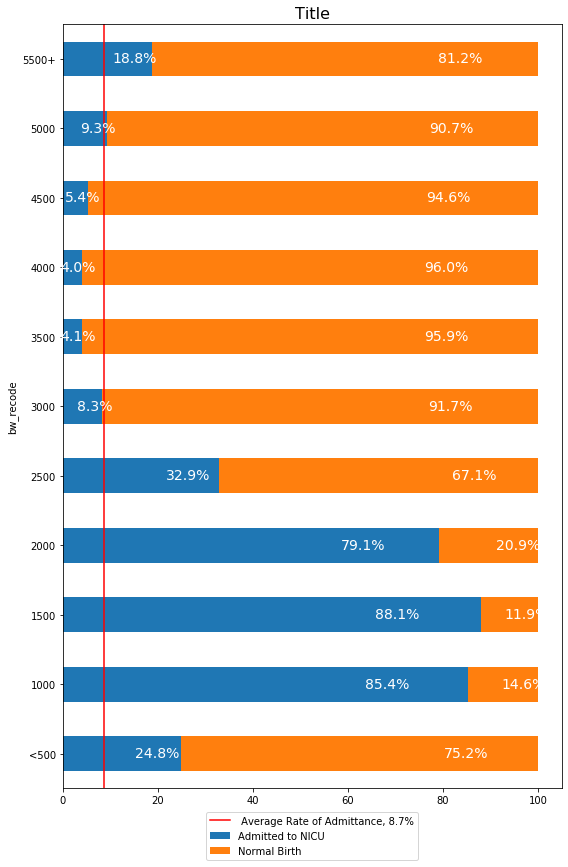

In [247]:
pct_bplot2(births_nou,'bw_recode')

-303.5151766004419 63155.51517660044 31729.515176600442
11.962849394824373 30.89671196094375 9.46693128305969


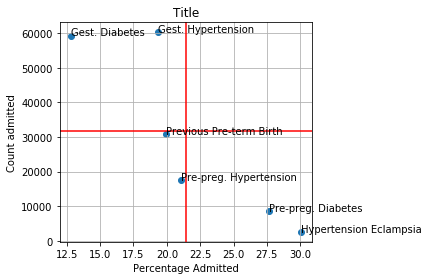

In [284]:
cnames_list = ['gest_diab','pre_preg_diab', 'gest_hypten', 'pre_preg_hypten', 'hypten_ecl', 'prev_preterm_birth']
fullnames_list =['Gest. Diabetes', "Pre-preg. Diabetes",'Gest. Hypertension', 'Pre-preg. Hypertension', 'Hypertension Eclampsia', 'Previous Pre-term Birth']
plt_scatter(births_nou,cnames_list, fullnames_list)



AttributeError: 'NoneType' object has no attribute 'tight_layout'

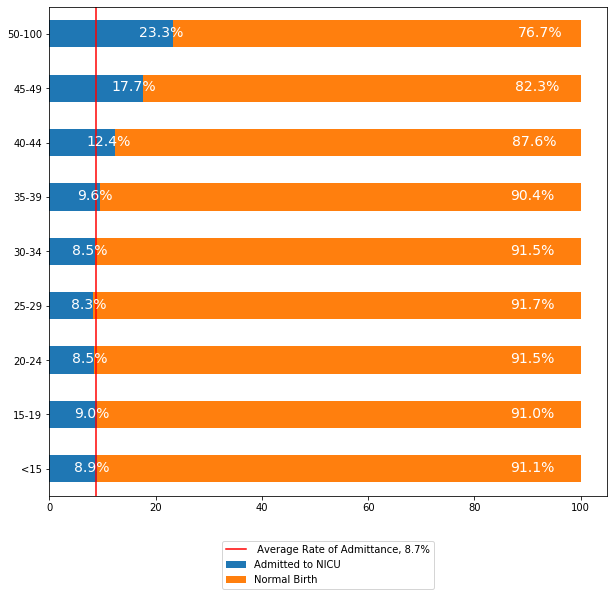

In [50]:
pct_bplot(births_nou, 'mothers_age_groups2', title = "",savefile = 'cln_mom_age_pct')

AttributeError: 'NoneType' object has no attribute 'set_xticklabels'

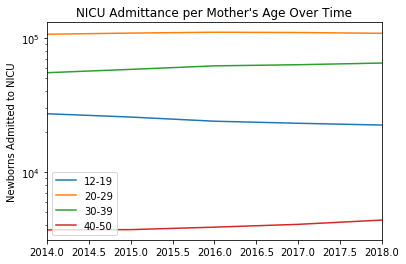

In [31]:
plt = plot_gpYR(births_nou,'mothers_age_groups',xlab = '',ylab= 'Newborns Admitted to NICU', title = "NICU Admittance per Mother's Age Over Time" ,kind='line')


In [47]:
# Make a dataframe suitable for plotting a bar graph with counts of one subcategory of feature
#For example inlcude only observations marked 'Y', exclude other values

def make_cntdf2(dataframe , group = str, filter_output = 'Y', target = 'admit_NICU',):
    return dataframe.loc[(dataframe[group] == filter_output)].count()
            

In [ ]:
def cnt_bhplot2(dataframe, full_names, col_names , target = 'admit_NICU', columns_titles = ['Y','N'], title = 'Title', savefile = 'newplot' ):
    df = pd.concat(map( lambda cname: make_cntdf2( births_nou, cname ), col_names ))
    df_plt = df.plot(kind = 'barh', width = 0.8, stacked = True, figsize = (13,9))
    
    #Formatting  
    df_plt.set_yticklabels(full_names, fontsize = 12)
    df_plt.set_title(title, fontsize = 16)
    leg = df_plt.legend(labels=['Admitted to NICU'],fontsize= 10, loc = 'lower center')
    
    #Add annotation 
    for p in df_plt.patches:
        width, height = p.get_width(), p.get_height()
        df_plt.annotate('{:}'.format(int(width)), ( p.get_x()+ width, p.get_y() + height - .5),
                          ha = 'left', color = 'black', fontsize = 12)
    # Get the bounding box of the original legend
    bb = leg.get_bbox_to_anchor().inverse_transformed(df_plt.transAxes)

    # Change to location of the legend. 
    Offset = -.1
    bb.y0 += Offset
    bb.y1 += Offset
    leg.set_bbox_to_anchor(bb, transform = df_plt.transAxes)

    #Resize plot area to fit within Figure Size
#     plt.subplots_adjust(right=0.9)  # adjust plot area
#     plt.tight_layout()
    saveplt(savefile)

AttributeError: 'NoneType' object has no attribute 'tight_layout'

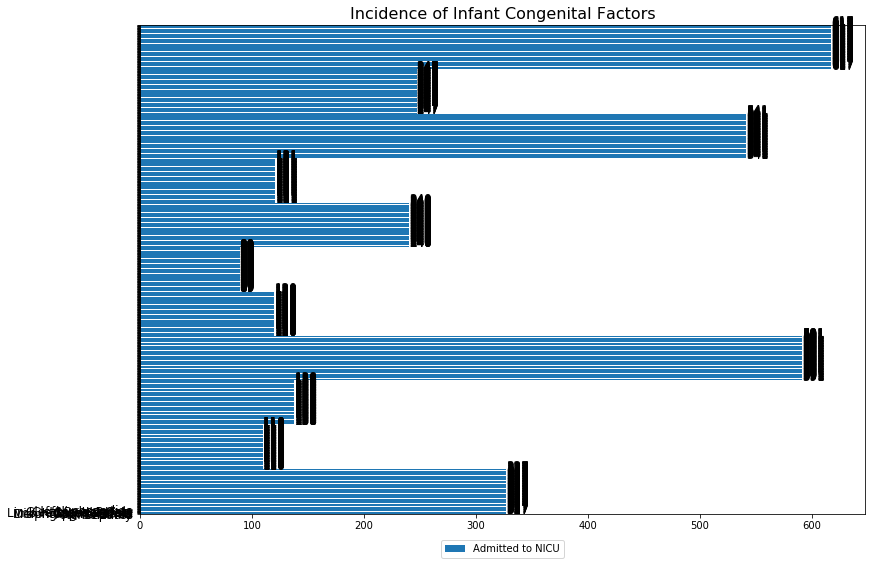

In [49]:
cnt_bhplot2(births_nou,lstinfant_congenital_fullnames,lstinfant_congenital_cnames, title = "Incidence of Infant Congenital Factors", savefile = 'cln_congenital_cnt')